In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
sns.set(style='whitegrid',context='notebook',font_scale=1.2)

## Reading Data

In [2]:
#layout file describing all columns
layout = pd.read_csv('public_layout.csv')

#data file
data = pd.read_csv('recs2009_public.csv')

In [3]:
layout.head()

Variable Name                          Variable Label  \
0              DOEID   Unique identifier for each respondent   
1            REGIONC                           Census Region   
2           DIVISION                         Census Division   
3  REPORTABLE_DOMAIN  Reportable states and groups of states   
4            TYPEHUQ                    Type of housing unit   

   Variable Order in File Variable Type  Length  
0                       1     Character       5  
1                       2       Numeric       8  
2                       3       Numeric       8  
3                       4       Numeric       8  
4                       5       Numeric       8

In [8]:
layout.shape

(931, 5)

There are 931 columns total.

In [4]:
data.shape

(12083, 931)

In [60]:
data.head()

DOEID  REGIONC  DIVISION  REPORTABLE_DOMAIN  TYPEHUQ       NWEIGHT  HDD65  \
0      1        2         4                 12        2   2471.679705   4742   
1      2        4        10                 26        2   8599.172010   2662   
2      3        1         1                  1        5   8969.915921   6233   
3      4        2         3                  7        2  18003.639600   6034   
4      5        1         1                  1        3   5999.605242   5388   

   CDD65  HDD30YR  CDD30YR    ...     SCALEEL  KAVALNG PERIODNG SCALENG  \
0   1080     4953     1271    ...           0       -2       -2      -2   
1    199     2688      143    ...           0        1        1       0   
2    505     5741      829    ...           0        3        5       3   
3    672     5781      868    ...           3        3        5       3   
4    702     5313      797    ...           0        1        1       0   

   PERIODLP  SCALELP  PERIODFO  SCALEFO  PERIODKR  SCALEKER  
0        -2       -2        -2       -2        -2        -2  
1        -2       -2        -2       -2        -2        -2  
2        -2       -2        -2       -2        -2        -2  
3        -2       -2        -2       -2        -2        -2  
4        -2       -2        -2       -2        -2        -2  

[5 rows x 931 columns]

In [3]:
#some useful functions for looking up data

def whatis(columns):
    #get column description
    #INPUT: columns - list of column names or a string of one column name
    try:
        for column in columns:
            print column,'=',layout.loc[layout['Variable Name'] == column,'Variable Label'].values[0]
    except:
        print columns,'=',layout.loc[layout['Variable Name'] == columns,'Variable Label'].values[0]

def search_columns(term):
    #search for columns contain term
    df = layout.loc[layout['Variable Label'].str.contains(term,case=False) | 
                    layout['Variable Name'].str.contains(term,case=False),['Variable Name','Variable Label']]
    return df

In [61]:
whatis('REGIONC')

R = REGIONC = Census Region


In [62]:
search_columns('Region')

Variable Name                                     Variable Label
1              REGIONC                                      Census Region
10  Climate_Region_Pub  Building America Climate Region (collapsed for...

In [56]:
data['TYPEHUQ'].value_counts()

2    3752
5     858
3     479
4     311
1     286
Name: TYPEHUQ, dtype: int64

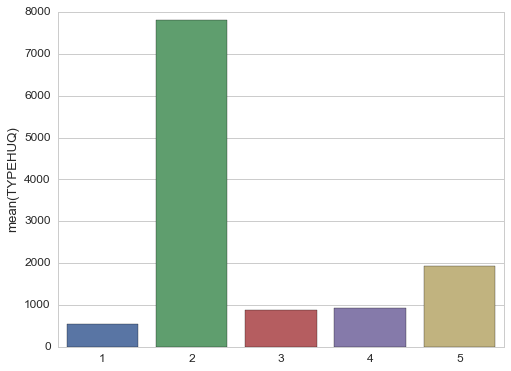

In [107]:
fig, ax = plt.subplots(figsize=[8,6])
sns.barplot(data['TYPEHUQ'].value_counts().index,y=data['TYPEHUQ'].value_counts())

## Exploratory Data Analysis

Electricity usage

In [63]:
print 'Mean, Std:', data['KWH'].mean(), data['KWH'].std()

Mean, Std: 11288.1593975 7641.19084518


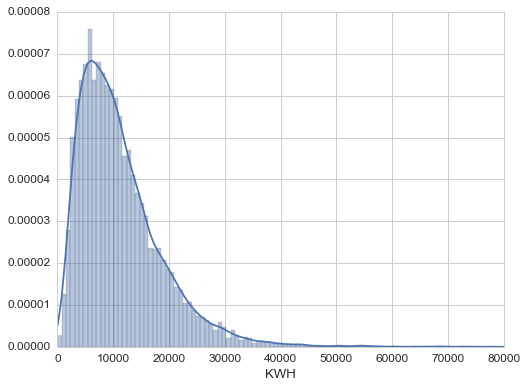

In [16]:
fig, ax = plt.subplots(figsize=[8,6])
ax.set_xlim(0,80000)
sns.distplot(data['KWH'],ax=ax, bins=100)
plt.savefig('KWH_dist.png',bbox_inches='tight')

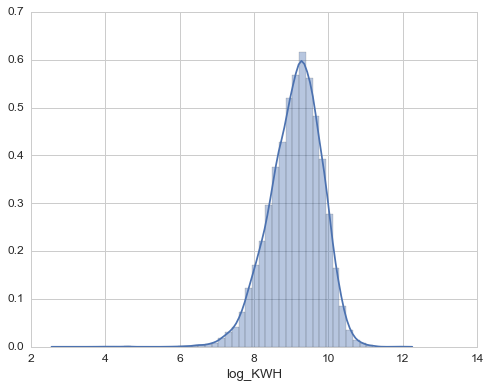

In [4]:
data['log_KWH'] = data['KWH'].map(np.log1p)
#Log plot
fig, ax = plt.subplots(figsize=[8,6])
#ax.set_xlim(0,80000)
sns.distplot(data['log_KWH'],ax=ax)

Look for outliers in KWH.

In [22]:
#Looking for data with log(KWH) larger than 3 standard deviation from the mean.
print 'Data > 3*Sigma:'
print data.loc[data['log_KWH'] > (data['log_KWH'].mean()+3.*data['log_KWH'].std()), 'KWH']

#Data with KWH larger than 60000
print 'Data > 60,000 KWH:'
print data.loc[data['KWH']>60000, 'KWH']

Data > 3*Sigma:
8112    77622
Name: KWH, dtype: int64
Data > 60,000 KWH:
1362     60183
4212     68382
4418     69007
4712     68289
4839     72865
8112     77622
9129     72725
10220    64232
Name: KWH, dtype: int64


There seem to be one entry with an unusually large KWH. Entry 3551. 

In [5]:
print 'SQRT:', data.loc[3551,'TOTSQFT_EN'], 'Rooms:', data.loc[3551,'TOTROOMS']

SQRT: 9545 Rooms: 23


In [5]:
#Removing this entry
data = data.drop(3551)

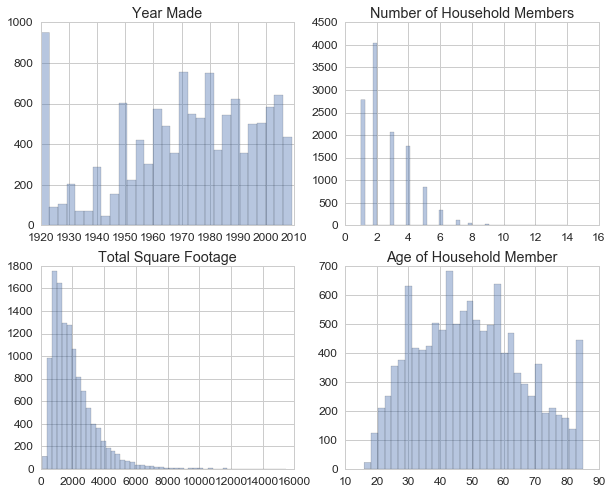

In [27]:
fig, axarr = plt.subplots(2,2,figsize=[10,8])
col = ['YEARMADE','NHSLDMEM','TOTSQFT_EN','HHAGE']
title = ['Year Made','Number of Household Members','Total Square Footage','Age of Household Member']
for i in range(4):
    axarr.flatten()[i].set_title(title[i])
    sns.distplot(data[col[i]],ax=axarr.flatten()[i],kde=False)
    axarr.flatten()[i].set_xlabel('')

plt.savefig('features_dist.png',bbox_inches='tight')

Some of these bins suggest some sensored data. For example, the year made started from 1920. Houses built prior to that year might be put as 1920. We can look at the imputation flag to see how many of these data points were imputed. Similarly for the age data.

In [69]:
data['ZYEARMADE'].value_counts()

0    7882
1     810
Name: ZYEARMADE, dtype: int64

In [70]:
data.loc[data['YEARMADE']==1920,'ZYEARMADE'].value_counts()

0    534
1     90
Name: ZYEARMADE, dtype: int64

Only about 15% were imputed. The number for 1920 is quite high. I wonder if this has something to do with the survey itself. We don't see any house that were built prior to 1920 eventhough the year range is reported to be 1600-2009. From the survey form, the participants were asked to fill in the estimate year the house was built.

Explore some other important features.

In [17]:
from sklearn.utils import resample

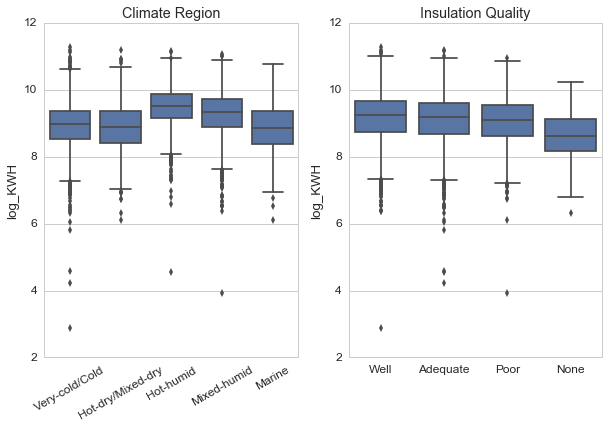

In [25]:
#Looking at some categorical features
fig, axarr = plt.subplots(1,2,figsize=[10,6])
axarr[0].set_title('Climate Region')
axarr[1].set_title('Insulation Quality')
b1 = sns.boxplot(ax=axarr[0],data=data,x='Climate_Region_Pub',y='log_KWH',color=sns.color_palette()[0])
b2 = sns.boxplot(ax=axarr[1],data=data,x='ADQINSUL',y='log_KWH',color=sns.color_palette()[0])
b1.set_xticklabels(['Very-cold/Cold','Hot-dry/Mixed-dry','Hot-humid','Mixed-humid','Marine'],rotation=30)
b2.set_xticklabels(['Well','Adequate','Poor','None'])
axarr[0].set_xlabel(''); axarr[1].set_xlabel('')

plt.savefig('climate_insul_box.png',bbox_inches='tight')

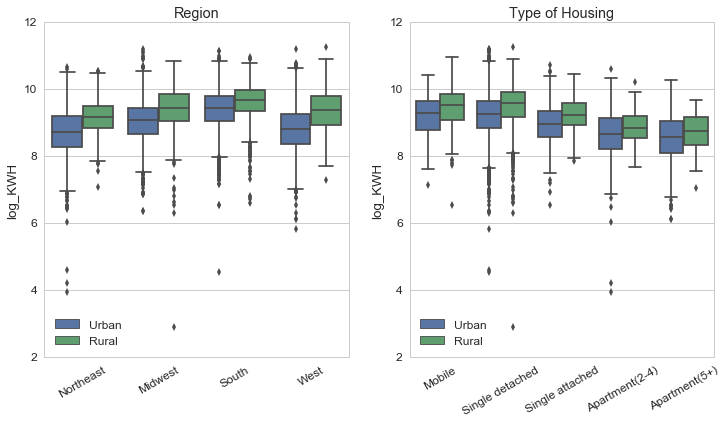

In [28]:
fig, axarr = plt.subplots(1,2,figsize=[12,6])
axarr[0].set_title('Region')
axarr[1].set_title('Type of Housing')
b1 = sns.boxplot(ax=axarr[0],data=data,x='REGIONC',y='log_KWH',hue='UR')
b2 = sns.boxplot(ax=axarr[1],data=data,x='TYPEHUQ',y='log_KWH',hue='UR')
b1.set_xticklabels(['Northeast','Midwest','South','West'],rotation=30)
b2.set_xticklabels(['Mobile','Single detached','Single attached','Apartment(2-4)','Apartment(5+)'],rotation=30)
handles, labels = axarr[0].get_legend_handles_labels()
axarr[0].legend(handles=handles,labels=['Urban','Rural'],loc=3)
axarr[1].legend(handles=handles,labels=['Urban','Rural'],loc=3)
axarr[0].set_xlabel(''); axarr[1].set_xlabel('')

plt.savefig('region_type_box.png',bbox_inches='tight')

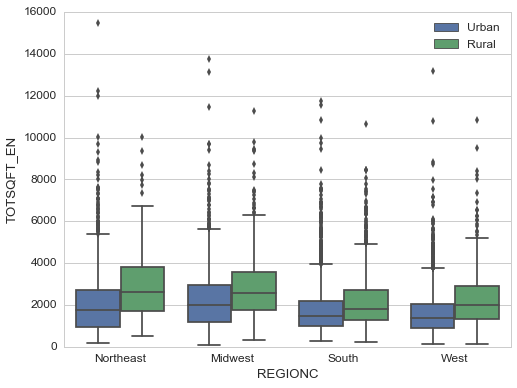

In [29]:
fig, ax = plt.subplots(figsize=[8,6])
b = sns.boxplot(ax=ax,data=data,x='REGIONC',y='TOTSQFT_EN',hue='UR')
b.set_xticklabels(['Northeast','Midwest','South','West'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles,labels=['Urban','Rural'])

plt.savefig('region_sqft_box.png',bbox_inches='tight')

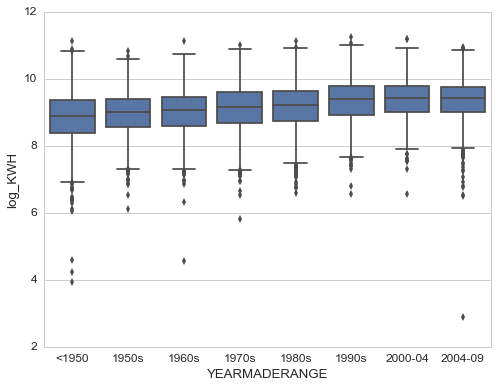

In [65]:
fig, ax = plt.subplots(figsize=[8,6])
b = sns.boxplot(ax=ax,data=data,x='YEARMADERANGE',y='log_KWH',color=sns.color_palette()[0])
b.set_xticklabels(['<1950','1950s','1960s','1970s','1980s','1990s','2000-04','2004-09'])

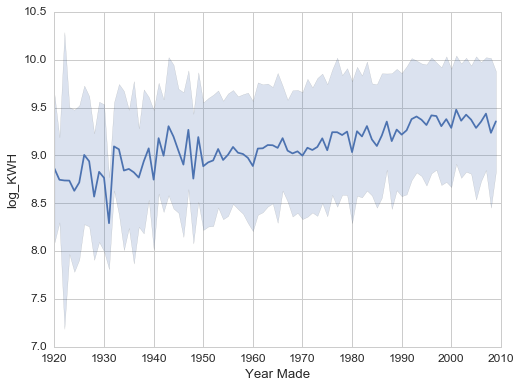

In [30]:
mean = data.groupby('YEARMADE')['log_KWH'].mean()
std = data.groupby('YEARMADE')['log_KWH'].std()
fig, ax = plt.subplots(figsize=[8,6])
ax.set(xlabel='Year Made',ylabel='log_KWH')
ax.plot(mean)
ax.fill_between(mean.index,mean-std,mean+std,alpha=0.2)

plt.savefig('yearmade_timeseries.png',bbox_inches='tight')

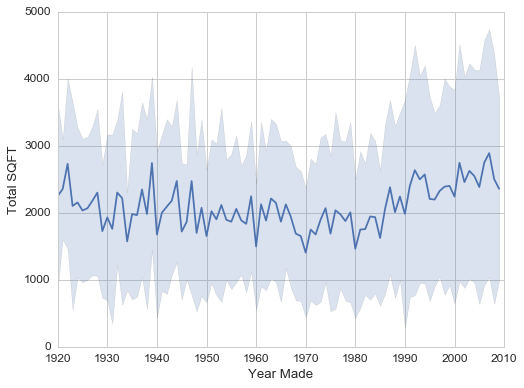

In [31]:
mean = data.groupby('YEARMADE')['TOTSQFT_EN'].mean()
std = data.groupby('YEARMADE')['TOTSQFT_EN'].std()
fig, ax = plt.subplots(figsize=[8,6])
ax.set(xlabel='Year Made',ylabel='Total SQFT')
ax.plot(mean)
ax.fill_between(mean.index,mean-std,mean+std,alpha=0.2)

plt.savefig('sqft_timeseries.png',bbox_inches='tight')

In [32]:
#Since we have more than 10k samples, we are resampling them for visualization purposes. 
subdata = resample(data, replace=False, n_samples= 1000, random_state=42)

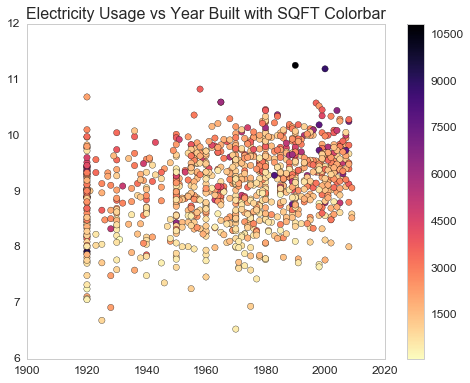

In [33]:
fig, ax = plt.subplots(figsize=[8,6])
ax.set_title('Electricity Usage vs Year Built with SQFT Colorbar',size=16)
ax.grid(b=False)
cax = ax.scatter(subdata['YEARMADE'],subdata['log_KWH'],c=subdata['TOTSQFT_EN'],cmap='magma_r',s=40)
cbar = fig.colorbar(cax)

plt.savefig('yearmade_sqft_kwh_scatter.png',bbox_inches='tight')

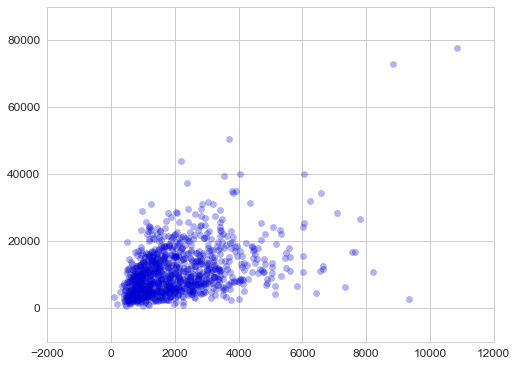

In [81]:
fig, ax = plt.subplots(figsize=[8,6])
ax.scatter(subdata['TOTSQFT_EN'],subdata['KWH'],s=40,alpha=0.3)

## Modeling

### Preprocessing

In [6]:
from scipy.stats import skew

In [7]:
#function for calculating error
def rms_error(y_pred,y_true):
    se = (y_pred - y_true)**2
    mse = np.mean(se)
    return (se,math.sqrt(mse))
se_arr = {}
rmse = {}

Calculating Pearson correlation coefficient for the quantitative columns

In [8]:
from scipy.stats.stats import pearsonr

#Calculate and print the Pearson correlation coefficient and the coresponding p-values
def calculate_rho(df,quant_col):
    for col in quant_col:
        corcoef = pearsonr(df[col],data['KWH'])
        print "%s: %8.2f P-value: %8.2f" % (col,corcoef[0],corcoef[1])

Convert N/A data (entry with value -2) to 0. 

In [9]:
#Deal with N/A entries for quantitative features and binary features
def convert_na(df, col):   
    arr = df[col].values
    arr[np.where(arr == -2)] = 0
    df.loc[:,col] = arr
    return df

Looking at skewness of quantitative features.

In [10]:
#Check skewness
def check_skew(df, quant_col):
    #filter out columns with discrete values 
    quant_col = [col for col in quant_col if df[col].nunique()>100]
    #calculate skewness
    high_skew_col = [col for col in quant_col if abs(skew(df[col]) > 1)]
    return high_skew_col

#log transform skewed columns
def take_log(df, skewed_col):
    for col in skewed_col:
        df.loc[:,col] = df[col].map(np.log1p)
    return df

Next, we will need to transform the categorical data into something that can be used in a model. Each categorical columns will need to be converted to multiple columns each corresponding to a single label with values of 1/0. We are dropping the first label for each column.

In [11]:
#Encoding Categorical data
def encode_qual(df,qual_col):
    return pd.get_dummies(df,columns=qual_col,prefix=qual_col,drop_first=True)

Put all the preprocessing together.

In [12]:
def preprocess(df, qual_col,quant_col,bin_col):
    df = convert_na(df,quant_col,bin_col)
    skewed_col = check_skew(df,quant_col)
    df = take_log(df,skewed_col)
    df = encode_qual(df,qual_col)
    return df

### Benchmarking: First Linear Regression Model

We will start with a simple linear regression model. How well can we predict electricity usage from few, main features? This will be our first benchmark.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression

In [39]:
#selecting columns
quan_col = ['YEARMADE','NHSLDMEM','TOTSQFT_EN']
qual_col = ['Climate_Region_Pub','TYPEHUQ']
whatis(quan_col+qual_col)

YEARMADE = Year housing unit was built
NHSLDMEM = Number of household members
TOTSQFT_EN = Total square footage (includes heated/cooled garages, all basements, and finished/heated/cooled attics). Used for EIA data tables.
Climate_Region_Pub = Building America Climate Region (collapsed for public file)
TYPEHUQ = Type of housing unit


In [40]:
df = data[quan_col+qual_col]

In [14]:
df.count()

YEARMADE              12082
NHSLDMEM              12082
TOTSQFT_EN            12082
Climate_Region_Pub    12082
TYPEHUQ               12082
dtype: int64

In [41]:
#Convert categorical data
df = encode_qual(df,qual_col)

In [32]:
df['TOTSQFT_EN'] = df['TOTSQFT_EN'].map(np.log1p)

In [17]:
calculate_rho(df,quan_col)

YEARMADE:     0.22 P-value:     0.00
NHSLDMEM:     0.28 P-value:     0.00
TOTSQFT_EN:     0.40 P-value:     0.00


All the correlation coefficients are positive but not very large. All of the p-values are less than 0.01. They are all significant (using the confidence level of 0.05), which is to be expected considering the large number of samples we have.  

Try a very simplistic linear model to see how well it does. 

In [42]:
X = df.values
y = data['KWH'].values
X.shape, y.shape

((12082, 11), (12082,))

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
print 'Train set r^2:', clf.score(X_train,y_train)
print 'Test set r^2:', clf.score(X_test,y_test)

Train set r^2: 0.378168413315
Test set r^2: 0.344701053149


In [21]:
f_value, p_value = f_regression(X,y.flatten())

In [64]:
for i in xrange(len(f_value)):
    print df.columns[i],'F-value:',"%6.0f" % f_value[i],' P-value:',"%5.2f" % p_value[i]
    

YEARMADE F-value:    606  P-value:  0.00
NHSLDMEM F-value:   1011  P-value:  0.00
TOTSQFT_EN F-value:   1997  P-value:  0.00
Climate_Region_Pub_2 F-value:    181  P-value:  0.00
Climate_Region_Pub_3 F-value:    636  P-value:  0.00
Climate_Region_Pub_4 F-value:    204  P-value:  0.00
Climate_Region_Pub_5 F-value:     61  P-value:  0.00
TYPEHUQ_2 F-value:   1464  P-value:  0.00
TYPEHUQ_3 F-value:     84  P-value:  0.00
TYPEHUQ_4 F-value:    324  P-value:  0.00
TYPEHUQ_5 F-value:   1034  P-value:  0.00


In [49]:
se_arr['BM_SLR'], rmse['BM_SLR'] = rms_error(clf.predict(X_test),y_test)

In [50]:
rmse['BM_SLR']

6061.581764080311

## Feature Selection

In [22]:
from sklearn.feature_selection import SelectKBest

In [16]:
#Reading column list from a file into a dict

column_list = {}
with open('columns_list2.txt') as f:
    lines = [line.rstrip() for line in f] 
lines = filter(None, lines)

for line in lines:
    col_name, list_txt = line.strip().replace(' ','').split('=')
    column_list[col_name] = list_txt.replace('[','').replace(']','').split(',')

### Selecting Housing Characteristics

In [15]:
qual_col = column_list['house_qual']
quant_col = column_list['house_quant']
bin_col = column_list['house_bin']

df = data[qual_col+quant_col+bin_col]
df = preprocess(df, qual_col,quant_col,bin_col)

NameError: name 'column_list' is not defined

Creating a train and test sets for the rest of the analysis. We want to keep this test set seperated and not do any CV on it. 

In [55]:
df_train, df_test, y_train, y_test = train_test_split(df, data['log_KWH'], test_size=0.2, random_state=42)

In [56]:
df_train.shape, df_test.shape

((9665, 366), (2417, 366))

In [20]:
def order_features(df_train,y_train, df_test):
    #Using SelectKBest to calculate f-value and p-value for each feature
    KBest = SelectKBest(f_regression,k=100)
    KBest.fit(df_train.values,y_train)
    
    #Create a Dataframe to store KBest result
    KBest_df = pd.DataFrame(index=df_train.columns)
    KBest_df['score'] = KBest.scores_
    KBest_df['p_value'] = KBest.pvalues_
    KBest_df = KBest_df.sort_values(by='score',ascending=False)
    
    print KBest_df.head(10)
    
    #order the columns by f-score
    df_train = df_train[KBest_df.index]
    df_test = df_test[KBest_df.index]
    return df_train, df_test

def compare_nfeatures(df_train, y_train):
    #Compare models with k features
    k_list = range(10,240,10) 
    train_score = []
    test_score = []

    X_train = df_train.values
    for k in k_list:
        #Need to evaluate on a CV set, so wee need to split the training set again
        X_CV_train, X_CV_test, y_CV_train, y_CV_test = train_test_split(
                    X_train[:,:k], y_train, test_size=0.3, random_state=34)
        clf = LinearRegression()
        clf.fit(X_CV_train,y_CV_train)
        train_score.append(clf.score(X_CV_train,y_CV_train))
        test_score.append(clf.score(X_CV_test,y_CV_test))
    return pd.Series(train_score,index=k_list), pd.Series(test_score,index=k_list)

def plot_nfeatures(train_score, test_score):
    #plot the scores
    fig, ax = plt.subplots(figsize=[8,6])
    ax.set_xlabel('Number of Features',size=16)
    ax.set_ylabel('$r^2$ Score',size=16)
    ax.xaxis.grid(b=False)
    ax.plot(train_score.index,train_score,'b--',label='Train Score')
    ax.plot(test_score.index, test_score,'r-',label='Test Score')
    ax.legend(loc=4,fontsize=14)
    
def select_features(df_train,df_test,test_score):
    for i in range(len(test_score)-5):
        if np.abs(test_score.iloc[i+5]-test_score.iloc[i]) < 0.005*test_score.iloc[i]:
            break
    k_best = test_score.index[i]
    print 'k_best:', k_best
    
    #select the top k_best features
    df_train = df_train.iloc[:,:k_best]
    df_test = df_test.iloc[:,:k_best]
    return df_train, df_test

In [58]:
df_train, df_test = order_features(df_train, y_train, df_test)

                  score        p_value
BEDROOMS    2580.520253   0.000000e+00
TOTROOMS    2526.759063   0.000000e+00
TOTSQFT     2269.731544   0.000000e+00
TOTSQFT_EN  2188.284609   0.000000e+00
NCOMBATH    1972.620985   0.000000e+00
TOTCSQFT    1761.506946   0.000000e+00
PELAC_1     1672.816602   0.000000e+00
TYPEHUQ_2   1624.091602   0.000000e+00
NAPTFLRS    1611.128146   0.000000e+00
REGIONC_3   1403.910461  5.157075e-287


In [59]:
train_score, test_score = compare_nfeatures(df_train, y_train)

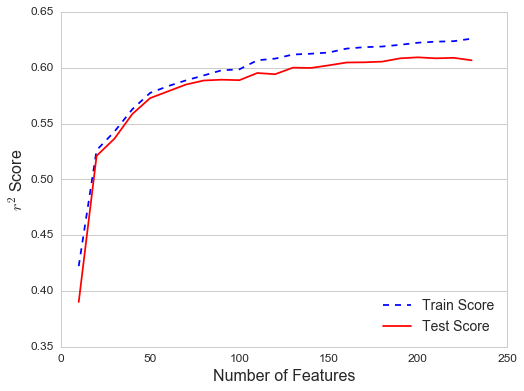

In [60]:
plot_nfeatures(train_score,test_score)

In [80]:
df_train, df_test = select_features(df_train,df_test,test_score)

k_best: 180


In [81]:
df_train.shape

(9665, 180)

### Fitting Linear Regression

In [90]:
#on test data
X_train = df_train.values
X_test = df_test.values
clf = LinearRegression()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.59200114218971733

In [91]:
se_arr['SLR'], rmse['SLR'] = rms_error(clf.predict(X_test),y_test)

In [92]:
rmse['SLR']

0.44377812080751006

In [93]:
residual = y_test - clf.predict(X_test)

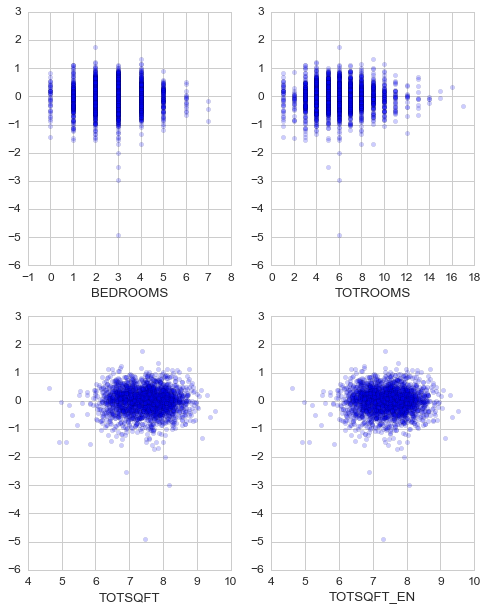

In [100]:
fig, axarr = plt.subplots(2,2,figsize=[8,10])

for i in range(4):
    axarr.flatten()[i].set_xlabel(df_train.columns[i])
    axarr.flatten()[i].scatter(X_test[:,i],residual,alpha=0.2)

#### Ridge

In [27]:
from sklearn.linear_model import Ridge

In [102]:
X_train = df_train.values
X_test = df_test.values

In [103]:
clf = Ridge(alpha=1)
clf.fit(df_train.values, y_train.values)
clf.score(X_test,y_test)

0.59217284222229183

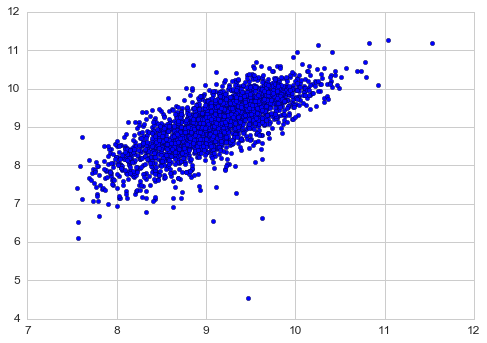

In [104]:
plt.scatter(clf.predict(X_test),y_test)
#plt.plot([0,50000],[0,50000],'k-')

#### Lasso

In [105]:
from sklearn.linear_model import Lasso

In [106]:
clf = Lasso(alpha=0.0005,normalize=True)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.51399413056246623

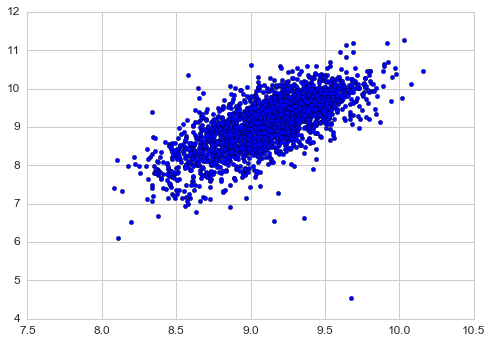

In [134]:
plt.scatter(clf.predict(X_test),y_test)
#plt.plot([0,50000],[0,50000],'k-')

### Adding household members data

In [107]:
qual_col = column_list['house_qual']+column_list['mem_qual']
quant_col = column_list['house_quant']+column_list['mem_quant']
bin_col = column_list['house_bin']+column_list['mem_bin']

df = data[qual_col+quant_col+bin_col]
df = preprocess(df, qual_col,quant_col,bin_col)

In [108]:
df_train, df_test, y_train, y_test = train_test_split(df, data['log_KWH'], test_size=0.2, random_state=42)

                  score        p_value
BEDROOMS    2580.520253   0.000000e+00
TOTROOMS    2526.759063   0.000000e+00
TOTSQFT     2269.731544   0.000000e+00
TOTSQFT_EN  2188.284609   0.000000e+00
NCOMBATH    1972.620985   0.000000e+00
TOTCSQFT    1761.506946   0.000000e+00
PELAC_1     1672.816602   0.000000e+00
TYPEHUQ_2   1624.091602   0.000000e+00
NAPTFLRS    1611.128146   0.000000e+00
REGIONC_3   1403.910461  5.157075e-287
k_best: 180


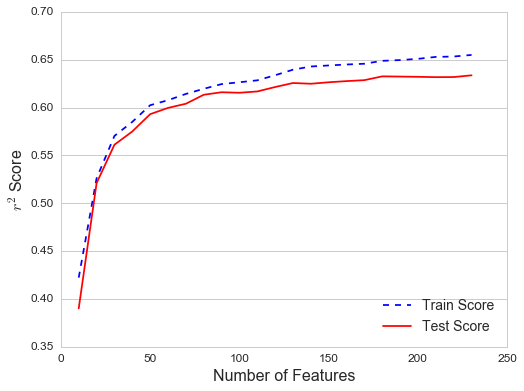

In [109]:
df_train, df_test = order_features(df_train, y_train, df_test)
train_score, test_score = compare_nfeatures(df_train, y_train)
plot_nfeatures(train_score,test_score)
df_train, df_test = select_features(df_train,df_test,test_score)

In [110]:
#Fitting Ridge Regression
X_train = df_train.values
X_test = df_test.values
clf = Ridge(alpha=1)
clf.fit(df_train.values, y_train.values)
clf.score(X_test,y_test)

0.62046615706144737

In [112]:
arr, e = rms_error(clf.predict(X_test),y_test)
e

0.4280176390385319

### Adding Appliances Data

In [17]:
qual_col = column_list['house_qual']+column_list['mem_qual']+column_list['app_qual']
quant_col = column_list['house_quant']+column_list['mem_quant']+column_list['app_quant']
bin_col = column_list['house_bin']+column_list['mem_bin']+column_list['app_bin']

df = data[qual_col+quant_col+bin_col]
df = preprocess(df, qual_col,quant_col,bin_col)

/Users/pear/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
df_train, df_test, y_train, y_test = train_test_split(df, data['log_KWH'], test_size=0.2, random_state=42)

                  score  p_value
ACROOMS     2902.258489      0.0
BEDROOMS    2580.520253      0.0
WASHLOAD    2574.793051      0.0
TOTROOMS    2526.759063      0.0
TOTSQFT     2269.731544      0.0
TOTSQFT_EN  2188.284609      0.0
HEATROOM    2170.480436      0.0
DRYER       1984.053452      0.0
NCOMBATH    1972.620985      0.0
DRYRFUEL_5  1898.605164      0.0
k_best: 180


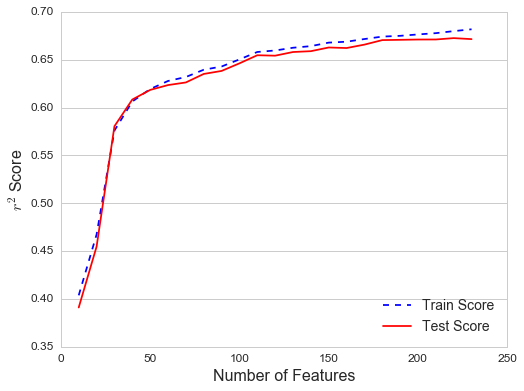

In [23]:
df_train, df_test = order_features(df_train, y_train, df_test)
train_score, test_score = compare_nfeatures(df_train, y_train)
plot_nfeatures(train_score,test_score)
df_train, df_test = select_features(df_train,df_test,test_score)

In [28]:
#Fitting Ridge Regression
X_train = df_train.values
X_test = df_test.values
clf = Ridge(alpha=1)
clf.fit(df_train.values, y_train.values)
clf.score(X_test,y_test)

0.66248598731725539

In [29]:
arr, e = rms_error(clf.predict(X_test),y_test)
e

0.4036289585048723

### Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [34]:
#CV 
n_features = X_train.shape[1]
params = {'max_features': np.linspace(math.sqrt(n_features),n_features,num=10,dtype='int'),
         'min_samples_leaf': range(1,20,5),
         'max_depth':range(2,7)}
clf = RandomForestRegressor(n_estimators=15)
CV = GridSearchCV(clf, param_grid=params)
CV.fit(X_train,y_train)
CV.best_params_

{'max_depth': 6, 'max_features': 142, 'min_samples_leaf': 16}

In [35]:
clf = RandomForestRegressor(max_features=CV.best_params_['max_features'],
                           min_samples_leaf=CV.best_params_['min_samples_leaf'])
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=142, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=16, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [36]:
print clf.score(X_train,y_train)
print clf.score(X_test,y_test)

0.718451449917
0.612889269011


In [37]:
arr, e = rms_error(clf.predict(X_test),y_test)
e

0.4322689273191349

In [116]:
scores = []
for n in xrange(1,30,4):
    clf = RandomForestRegressor(n_estimators=n,
        max_features=CV.best_params_['max_features'],
        min_samples_leaf=CV.best_params_['min_samples_leaf'])
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))

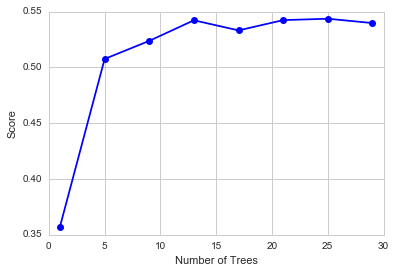

In [117]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Score')
plt.plot(xrange(1,30,4),scores,'bo-')

In [121]:
print 'Train set r^2:', clf.score(X_train,y_train)
print 'Test set r^2:', clf.score(X_test,y_test)

Train set r^2: 0.775778017398
Test set r^2: 0.540311914208


In [38]:
feat_imp = pd.DataFrame(index=df_train.columns)
feat_imp['imp'] = clf.feature_importances_

In [41]:
feat_imp.sort_values(by='imp', ascending=False).head(10)

imp
TOTCSQFT    0.257500
ELWATER     0.080325
WASHLOAD    0.059960
FUELHEAT_5  0.047102
TOTROOMS    0.038325
ACROOMS     0.038108
DRYRFUEL_5  0.036661
NHSLDMEM    0.036514
NAPTFLRS    0.035057
BEDROOMS    0.031722

### Trying Things

In [15]:
#Reading column list from a file into a dict

column_list = {}
with open('columns_list.txt') as f:
    lines = [line.rstrip() for line in f] 
lines = filter(None, lines)

for line in lines:
    col_name, list_txt = line.strip().replace(' ','').split('=')
    column_list[col_name] = list_txt.replace('[','').replace(']','').split(',')

In [38]:
df = data[column_list['house_qual']+column_list['house_quant']+column_list['house_bin']]

In [39]:
df = preprocess(df,column_list['house_qual'],column_list['house_quant'],column_list['house_bin'])

In [40]:
df.head()

HDD65     CDD65  HDD30YR   CDD30YR  YEARMADE  NUMFLRS   NUMAPTS  NAPTFLRS  \
0   4742  6.985642     4953  7.148346      2004        0  0.000000         0   
1   2662  5.298317     2688  4.969813      1998        0  0.000000         0   
2   6233  6.226537     5741  6.721426      1965        2  2.197225         1   
3   6034  6.511745     5781  6.767343      1985        0  0.000000         0   
4   5388  6.555357     5313  6.682109      1983        0  0.000000         0   

   BEDROOMS  NCOMBATH    ...      LPGPAY_2  LPGPAY_3  OTHERWAYLPG_1  \
0         4         1    ...           0.0       0.0            0.0   
1         3         2    ...           0.0       0.0            0.0   
2         1         1    ...           0.0       0.0            0.0   
3         3         2    ...           0.0       0.0            0.0   
4         2         1    ...           0.0       0.0            0.0   

   OTHERWAYLPG_2  OTHERWAYLPG_3  WOODAMT_1  WOODAMT_2  WOODAMT_3  WOODAMT_4  \
0            0.0            0.0        0.0        0.0        0.0        0.0   
1            0.0            0.0        0.0        1.0        0.0        0.0   
2            0.0            0.0        0.0        0.0        0.0        0.0   
3            0.0            0.0        0.0        0.0        0.0        0.0   
4            0.0            0.0        0.0        0.0        0.0        0.0   

   WOODAMT_5  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  

[5 rows x 399 columns]

In [43]:
X = df.values
y = data['log_KWH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
clf.score(X_train,y_train)

0.63194188709931876

In [45]:
clf.score(X_test,y_test)

0.59552942029692313

In [46]:
err_arr, e = rms_error(clf.predict(X_test),y_test)

In [49]:
e

0.44185510996719984

In [66]:
clf = Lasso(alpha=0.005)
clf.fit(X_train,y_train)

Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [67]:
clf.score(X_train,y_train)

0.58737735843144256

In [68]:
clf.score(X_test,y_test)

0.56861725126851848

In [81]:
len(np.where(clf.coef_ == 0)[0])/float(len(clf.coef_))

0.8621553884711779

In [82]:
err_arr, e = rms_error(clf.predict(X_test),y_test)

In [83]:
e

0.4563182096016526

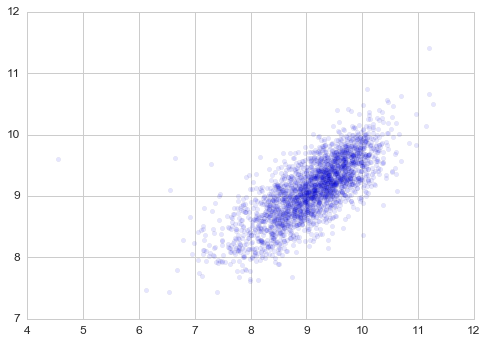

In [90]:
plt.scatter(y_test,clf.predict(X_test),alpha=0.1)

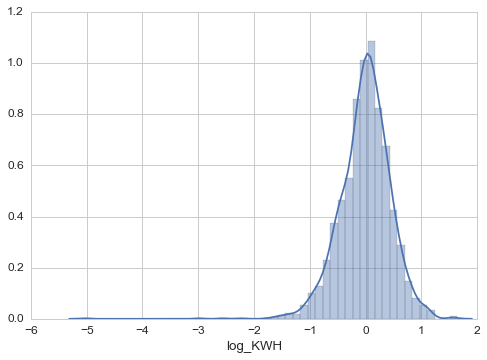

In [89]:
sns.distplot(y_test-clf.predict(X_test))

In [20]:
qual_col = column_list['house_qual']+column_list['mem_qual']
quant_col = column_list['house_quant']+column_list['mem_quant']
bin_col = column_list['house_bin']+column_list['mem_bin']

df = data[qual_col+quant_col+bin_col]

In [92]:
df.head()

REGIONC  DIVISION  REPORTABLE_DOMAIN  TYPEHUQ  Climate_Region_Pub  \
0        2         4                 12        2                   4   
1        4        10                 26        2                   5   
2        1         1                  1        5                   1   
3        2         3                  7        2                   1   
4        1         1                  1        3                   1   

   AIA_Zone METROMICRO UR  KOWNRENT  CONDCOOP    ...     RETIREPY  SSINCOME  \
0         3      METRO  U         1        -2    ...            0         0   
1         4      METRO  U         2        -2    ...            0         0   
2         2      METRO  U         2        -2    ...            0         0   
3         2      METRO  U         1        -2    ...            1         0   
4         3      METRO  U         1         1    ...            0         0   

   CASHBEN  INVESTMT  RGLRPAY  POVERTY100  POVERTY150  HUPROJ  RENTHELP  \
0        0         0        0           0           0      -2        -2   
1        0         0        0           0           1       0         1   
2        0         0        0           0           0       0         0   
3        0         1        0           0           0      -2        -2   
4        0         0        0           0           0      -2        -2   

   FOODASST  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 202 columns]

In [93]:
df = preprocess(df,qual_col,quant_col,bin_col)

In [94]:
df.head()

HDD65     CDD65  HDD30YR   CDD30YR  YEARMADE  NUMFLRS   NUMAPTS  NAPTFLRS  \
0   4742  6.985642     4953  7.148346      2004        0  0.000000         0   
1   2662  5.298317     2688  4.969813      1998        0  0.000000         0   
2   6233  6.226537     5741  6.721426      1965        2  2.197225         1   
3   6034  6.511745     5781  6.767343      1985        0  0.000000         0   
4   5388  6.555357     5313  6.682109      1983        0  0.000000         0   

   BEDROOMS  NCOMBATH       ...         AGEHHMEMCAT5_4  AGEHHMEMCAT5_5  \
0         4         1       ...                    0.0             0.0   
1         3         2       ...                    0.0             0.0   
2         1         1       ...                    0.0             0.0   
3         3         2       ...                    0.0             0.0   
4         2         1       ...                    0.0             0.0   

   AGEHHMEMCAT5_6  AGEHHMEMCAT5_7  AGEHHMEMCAT5_8  AGEHHMEMCAT5_9  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   AGEHHMEMCAT5_10  AGEHHMEMCAT5_11  AGEHHMEMCAT5_12  AGEHHMEMCAT5_18  
0              0.0              0.0              0.0              0.0  
1              0.0              0.0              0.0              0.0  
2              0.0              0.0              0.0              0.0  
3              0.0              0.0              0.0              0.0  
4              0.0              0.0              0.0              0.0  

[5 rows x 508 columns]

In [95]:
X = df.values
y = data['log_KWH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [96]:
clf.score(X_train,y_train)

0.67436705437955968

In [97]:
clf.score(X_test,y_test)

0.62899936891997721

In [98]:
err_arr, e = rms_error(clf.predict(X_test),y_test)

In [99]:
e

0.42317863885421125

In [36]:
qual_col = column_list['house_qual']+column_list['mem_qual']+column_list['app_qual']
quant_col = column_list['house_quant']+column_list['mem_quant']+column_list['app_quant']
bin_col = column_list['house_bin']+column_list['mem_bin']+column_list['app_bin']

df = data[qual_col+quant_col+bin_col]

In [37]:
df.head()

REGIONC  DIVISION  REPORTABLE_DOMAIN  TYPEHUQ  Climate_Region_Pub  \
0        2         4                 12        2                   4   
1        4        10                 26        2                   5   
2        1         1                  1        5                   1   
3        2         3                  7        2                   1   
4        1         1                  1        3                   1   

   AIA_Zone METROMICRO UR  KOWNRENT  CONDCOOP    ...     DUCTS  CENACHP  \
0         3      METRO  U         1        -2    ...        -2        0   
1         4      METRO  U         2        -2    ...        -2        0   
2         2      METRO  U         2        -2    ...        -2       -2   
3         2      METRO  U         1        -2    ...        -2        0   
4         3      METRO  U         1         1    ...        -2       -2   

   ACOTHERS  MAINTAC  THERMAINAC  PROTHERMAC  AUTOCOOLNITE  AUTOCOOLDAY  \
0         0        1           1           1             1            1   
1         0        0           1           0            -2           -2   
2        -2       -2          -2          -2            -2           -2   
3         0        0           1           0            -2           -2   
4        -2       -2          -2          -2            -2           -2   

   TREESHAD  NOTMOIST  
0         0         0  
1         0         0  
2         1         0  
3         0         0  
4         0         0  

[5 rows x 427 columns]

In [114]:
df = preprocess(df,qual_col,quant_col,bin_col)

In [115]:
df.head()

HDD65     CDD65  HDD30YR   CDD30YR  YEARMADE  NUMFLRS   NUMAPTS  NAPTFLRS  \
0  4742.0  6.985642   4953.0  7.148346    2004.0      0.0  0.000000       0.0   
1  2662.0  5.298317   2688.0  4.969813    1998.0      0.0  0.000000       0.0   
2  6233.0  6.226537   5741.0  6.721426    1965.0      2.0  2.197225       1.0   
3  6034.0  6.511745   5781.0  6.767343    1985.0      0.0  0.000000       0.0   
4  5388.0  6.555357   5313.0  6.682109    1983.0      0.0  0.000000       0.0   

   BEDROOMS  NCOMBATH      ...        USEWWAC_3  USECFAN_1  USECFAN_2  \
0       4.0       1.0      ...              0.0        0.0        0.0   
1       3.0       2.0      ...              0.0        0.0        0.0   
2       1.0       1.0      ...              0.0        0.0        1.0   
3       3.0       2.0      ...              0.0        1.0        0.0   
4       2.0       1.0      ...              0.0        0.0        0.0   

   USECFAN_3  USECFAN_4  USENOTMOIST_1  USENOTMOIST_2  USENOTMOIST_3  \
0        1.0        0.0            0.0            0.0            0.0   
1        0.0        0.0            0.0            0.0            0.0   
2        0.0        0.0            0.0            0.0            0.0   
3        0.0        0.0            0.0            0.0            0.0   
4        0.0        0.0            0.0            0.0            0.0   

   USENOTMOIST_4  USENOTMOIST_5  
0            0.0            0.0  
1            0.0            0.0  
2            0.0            0.0  
3            0.0            0.0  
4            0.0            0.0  

[5 rows x 1176 columns]

In [118]:
X = df.values
y = data['log_KWH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [119]:
clf.score(X_train,y_train)

0.7370408389932025

In [120]:
clf.score(X_test,y_test)

0.66220316956996761

In [121]:
err_arr, e = rms_error(clf.predict(X_test),y_test)

In [122]:
e

0.40379803226917743

#### Add interaction terms

In [17]:
df.shape

(12082, 427)

In [38]:
def preprocess(df, qual_col,quant_col,bin_col):
    df = convert_na(df,quant_col,bin_col)
    df = encode_qual(df,qual_col)
    return df

In [39]:
df = preprocess(df,qual_col,quant_col,bin_col)

In [40]:
df.head()

HDD65   CDD65  HDD30YR  CDD30YR  YEARMADE  NUMFLRS  NUMAPTS  NAPTFLRS  \
0  4742.0  1080.0   4953.0   1271.0    2004.0      0.0      0.0       0.0   
1  2662.0   199.0   2688.0    143.0    1998.0      0.0      0.0       0.0   
2  6233.0   505.0   5741.0    829.0    1965.0      2.0      8.0       1.0   
3  6034.0   672.0   5781.0    868.0    1985.0      0.0      0.0       0.0   
4  5388.0   702.0   5313.0    797.0    1983.0      0.0      0.0       0.0   

   BEDROOMS  NCOMBATH      ...        USEWWAC_3  USECFAN_1  USECFAN_2  \
0       4.0       1.0      ...              0.0        0.0        0.0   
1       3.0       2.0      ...              0.0        0.0        0.0   
2       1.0       1.0      ...              0.0        0.0        1.0   
3       3.0       2.0      ...              0.0        1.0        0.0   
4       2.0       1.0      ...              0.0        0.0        0.0   

   USECFAN_3  USECFAN_4  USENOTMOIST_1  USENOTMOIST_2  USENOTMOIST_3  \
0        1.0        0.0            0.0            0.0            0.0   
1        0.0        0.0            0.0            0.0            0.0   
2        0.0        0.0            0.0            0.0            0.0   
3        0.0        0.0            0.0            0.0            0.0   
4        0.0        0.0            0.0            0.0            0.0   

   USENOTMOIST_4  USENOTMOIST_5  
0            0.0            0.0  
1            0.0            0.0  
2            0.0            0.0  
3            0.0            0.0  
4            0.0            0.0  

[5 rows x 1176 columns]

In [59]:
X = df.values
y = data['log_KWH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [60]:
clf.score(X_train,y_train)

0.73481870807823335

In [61]:
clf.score(X_test,y_test)

-46024904.741229013

In [54]:
from sklearn.linear_model import Lasso

In [62]:
clf = Lasso()

In [63]:
clf.fit(X_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [64]:
clf.score(X_train,y_train)

0.31267161336483251

In [65]:
clf.score(X_test,y_test)

0.29300622343296567